### Submitted by:
Ashfaque Sami (z5430347)

# **Part 1. Topic Classification**






### Question 1
In the notebook from the tutorial there are two simplifications that might limit  the reliability and accuracy of our results. Below I would discuss the simplification what are the resultant of them  and suggest fixes for them.

* The regex
might remove too many special characters:  

Issue: Regex may be a more aggresive approach of text preprocessing which may remove potentially useful characters while removing unwanted symbols, which may be crucial for semantics. This may reduce the classifier's effectiveness as it may trigger loss of valuable information.

Fix : In order to preserve structure and context of the text which is crucial  for effective learning of the classifier. I will modify the regex so that it retains apostrophes and hyphens within words as they can have important role for understanding context.
*    the evaluation is based on only one training-
test split rather than using cross-validation:

Issue: In order to evaluate the model performance using just one train test split is not an optimal choice as the evaluation will compulsively depend on how the data is being split.This may not  be the perfect representation of the dataset.

Fix: We can  use k-fold cross-validation. In this process we  split the data into several folds, training and testing on each, and then averaing from the results.I will use straification, which ensures that the distribution remains consistent in each fold. This will give a more optimal evaluation of the model performance.

###Question 2
For classifaction we would use multinomial Navie Bayes (MNB) models the frequency of each word in a document to predict its class. Before the classifiaction we would examine the text preprocessing  steps to  determine the optimal solution for our use case. We will  be considerin the steps
below :

*  Lowercasing text
*  Removing special characters
*  Removing stopwords
*  Stemming
*  Removing single-letter words

Each song is being converted to a single  document by concatenating all fields. We would evaluate each preprocessing combination using 5-fold stratified cross-validation and default settings for CountVectorizer.








In [25]:
from google.colab import drive
drive.mount('/content/drive')
!pip install nltk
import nltk
nltk.download('stopwords')
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score, StratifiedKFold
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re


dataSetPath = '/content/drive/MyDrive/Comp9727 Assignment./dataset.tsv'
dataset = pd.read_csv(dataSetPath, sep="\t", names=["artist", "track", "release_date", "genre", "lyrics", "topic"])

# Combine all song fields into one document
def make_document(row):
    return f"{row['artist']} {row['track']} {row['release_date']} {row['genre']} {row['lyrics']}"
dataset['document'] = dataset.apply(make_document, axis=1)
X_Raw = dataset['document'].values
y = dataset['topic'].values

def preprocessing(text, lowercase=True, remove_special=True, Stopword_List=None, stemming=False):
    if lowercase:
        text = text.lower()
    if remove_special:
        text = re.sub(r"[^\w\s]", " ", text)
    tokens = text.split()
    tokens = [t for t in tokens if len(t) > 1]
    if Stopword_List:
        tokens = [t for t in tokens if t not in Stopword_List]
    if stemming:
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(t) for t in tokens]
    return " ".join(tokens)

Stopword_List = set(stopwords.words('english'))

# Trying different preprocessing combinations
options = [
    {'desc': 'Lowercase, remove special', 'lowercase': True, 'remove_special': True, 'Stopword_List': None, 'stemming': False},
    {'desc': 'Lowercase, remove special, stopwords', 'lowercase': True, 'remove_special': True, 'Stopword_List': Stopword_List, 'stemming': False},
    {'desc': 'Lowercase, remove special, stemming', 'lowercase': True, 'remove_special': True, 'Stopword_List': None, 'stemming': True},
    {'desc': 'Lowercase, remove special, stopwords, stemming', 'lowercase': True, 'remove_special': True, 'Stopword_List': Stopword_List, 'stemming': True},
]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []

for opt in options:
    X_processed = [preprocessing(x, **{k: opt[k] for k in opt if k != 'desc'}) for x in X_Raw]
    X_vec = CountVectorizer().fit_transform(X_processed)
    clf = MultinomialNB()
    scores = cross_val_score(clf, X_vec, y, cv=cv, scoring='accuracy')
    results.append({'desc': opt['desc'], 'mean_acc': scores.mean()})

results_DataFrame = pd.DataFrame(results)
print(results_DataFrame.sort_values('mean_acc', ascending=False))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


                                             desc  mean_acc
3  Lowercase, remove special, stopwords, stemming  0.790819
2             Lowercase, remove special, stemming  0.789491
1            Lowercase, remove special, stopwords  0.785493
0                       Lowercase, remove special  0.784162


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


The highest accuracy was achieved with Lowercase, remove special, stopwords, stemming which is (mean_acc ≈ 0.79).
This preprocessing pipeline will be used for both BNB and MNB in all following experiments.

### Question 3
To compare BNB and MNB, we are going to use 5-fold stratified cross-validation on the full dataset, applying the best preprocessing pipeline that we determined in question 2.

Classification metrics:


*   Accuracy : Overall proportion of correct prediction.
*   Precision: In this way we measure the proportion of correct predictions for each class,averaged over all classes.
*   Recall: This measures the proportion of actual class instances correctly predicted.
*   F1 Score: This is the harmonic mean of macro precision and recall.

Trade-off:
 Although accuracy is insightful for a balanced dataset but when we are using an imbalanced dataset F1 is a superior metric as it gives equal weight to every class of the dataset.







In [26]:
import collections
data_Set = pd.read_csv(dataSetPath, sep="\t", names=["artist", "track", "release_date", "genre", "lyrics", "topic"])
y = data_Set['topic'].values
print(collections.Counter(y))


Counter({'dark': 490, 'sadness': 376, 'personal': 347, 'lifestyle': 205, 'emotion': 82, 'topic': 1})


We can see that the dataset is imbalanced.

Now we will compare both models using the classification metrics

In [27]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.model_selection import cross_validate, StratifiedKFold
import pandas as pd

X_Processed = [preprocessing(x, lowercase=True, remove_special=True, Stopword_List=Stopword_List, stemming=True) for x in X_Raw]

Vectorized_mnb = CountVectorizer()
X_mnb = Vectorized_mnb.fit_transform(X_Processed)
Vectorized_bnb = CountVectorizer(binary=True)
X_bnb = Vectorized_bnb.fit_transform(X_Processed)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

# MNB
mnb = MultinomialNB()
mnb_scores = cross_validate(mnb, X_mnb, y, cv=cv, scoring=scoring)

# BNB
bnb = BernoulliNB()
bnb_scores = cross_validate(bnb, X_bnb, y, cv=cv, scoring=scoring)

# Results
results = pd.DataFrame({
    'MNB': [mnb_scores['test_accuracy'].mean(), mnb_scores['test_precision_macro'].mean(), mnb_scores['test_recall_macro'].mean(), mnb_scores['test_f1_macro'].mean()],
    'BNB': [bnb_scores['test_accuracy'].mean(), bnb_scores['test_precision_macro'].mean(), bnb_scores['test_recall_macro'].mean(), bnb_scores['test_f1_macro'].mean()]
}, index=['Accuracy', 'Precision (macro)', 'Recall (macro)', 'F1 (macro)'])
print(results)


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use

                        MNB       BNB
Accuracy           0.790819  0.530330
Precision (macro)  0.688701  0.399323
Recall (macro)     0.635025  0.375164
F1 (macro)         0.649450  0.339265


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predic

From the results we can determine that MNB is achieving higher score on all metrics compared to BNB.The accuracy and F1 is higer for MNB than BNB. As we have an imbalanced dataset F1 is the optimal metric for evaluation and clearly MNB superior.

<Axes: title={'center': 'BNB vs MNB Performance'}>

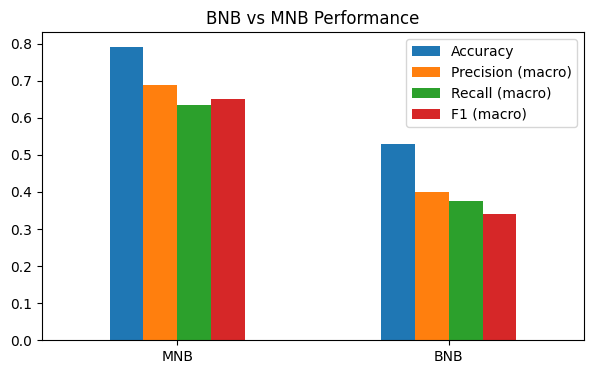

In [28]:
results.T.plot(kind='bar', figsize=(7,4), rot=0, title="BNB vs MNB Performance")


###Question 4

In order to limit the vocabulary to the top N most frequent words we used the max_feathure parameter in the CountVectorizer and investigate  how the numbers of features are affecting the classification. Using the preprocessing pipeline from earlier  we can evaluate both MNB and BNB across a range of N values.

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklea

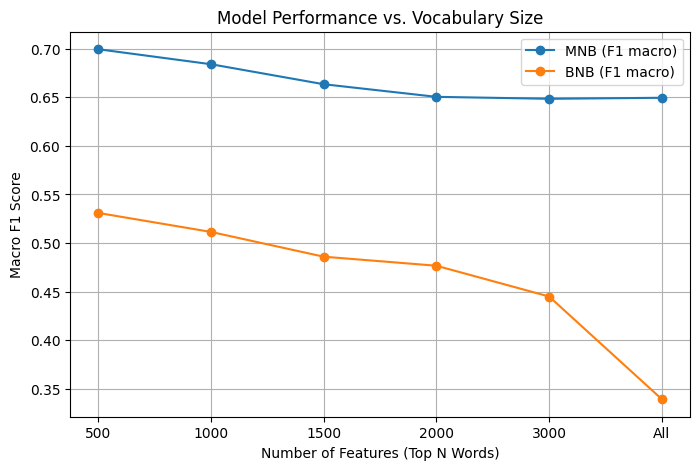

,N,MNB_F1_macro,BNB_F1_macro
0,500,0.699427,0.530968
1,1000,0.683998,0.511418
2,1500,0.663407,0.485940
3,2000,0.650428,0.476625
4,3000,0.648411,0.444958
5,All,0.649450,0.339265


In [29]:
import matplotlib.pyplot as plt

feature_nums = [500, 1000, 1500, 2000, 3000, None]
mnb_scores = []
bnb_scores = []

for n in feature_nums:
    # For MNB
    Vectorized_mnb = CountVectorizer(max_features=n)
    X_mnb = Vectorized_mnb.fit_transform(X_processed)
    mnb = MultinomialNB()
    mnb_f1 = cross_val_score(mnb, X_mnb, y, cv=cv, scoring='f1_macro').mean()
    mnb_scores.append(mnb_f1)

    # For BNB
    Vectorized_bnb = CountVectorizer(max_features=n, binary=True)
    X_bnb = Vectorized_bnb.fit_transform(X_processed)
    bnb = BernoulliNB()
    bnb_f1 = cross_val_score(bnb, X_bnb, y, cv=cv, scoring='f1_macro').mean()
    bnb_scores.append(bnb_f1)

# Preparing N for plotting
N_labels = [n if n is not None else 'All' for n in feature_nums]

# Plot results
plt.figure(figsize=(8,5))
plt.plot(N_labels, mnb_scores, marker='o', label='MNB (F1 macro)')
plt.plot(N_labels, bnb_scores, marker='o', label='BNB (F1 macro)')
plt.xlabel('Number of Features (Top N Words)')
plt.ylabel('Macro F1 Score')
plt.title('Model Performance vs. Vocabulary Size')
plt.legend()
plt.grid()
plt.show()

# Print the scores as table
import pandas as pd
pd.DataFrame({'N': N_labels, 'MNB_F1_macro': mnb_scores, 'BNB_F1_macro': bnb_scores})


From above we can notice that for both MNB and BNB peaks at N=500 in F1 score. From this point the performance of the classifiers gradually declines. Hence we can selecct 500 as our optimal value for the number of features.

###Question 5

I choose SVM as my other machine learing algorithm.  SVM is a supervised learning algorithm which is  used for classification tasks. SVM tries to find the best hyperplane that separates data points from different classes with the widest margin. For text data, a linear SVM ia commonly used  as the data is sparse and high-dimensional.

####Hypothesis
I expect linear linear SVM to have equal performance to MNB and BNB if not better than that , as it does not make the  naive word independence assumption and can find more  flexible desicion boundaries between classes.

In [30]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score, StratifiedKFold
import pandas as pd

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

N = 500
X_proc = [preprocessing(x, lowercase=True, remove_special=True, Stopword_List=Stopword_List, stemming=True) for x in X_Raw]

# Multinomial Naive Bayes
Vectorized_mnb = CountVectorizer(max_features=N)
X_mnb = Vectorized_mnb.fit_transform(X_proc)
mnb = MultinomialNB()
mnb_acc = cross_val_score(mnb, X_mnb, y, cv=cv, scoring='accuracy').mean()
mnb_f1 = cross_val_score(mnb, X_mnb, y, cv=cv, scoring='f1_macro').mean()

# Bernoulli Naive Bayes
Vectorized_bnb = CountVectorizer(max_features=N, binary=True)
X_bnb = Vectorized_bnb.fit_transform(X_proc)
bnb = BernoulliNB()
bnb_acc = cross_val_score(bnb, X_bnb, y, cv=cv, scoring='accuracy').mean()
bnb_f1 = cross_val_score(bnb, X_bnb, y, cv=cv, scoring='f1_macro').mean()

# Linear SVM
Vectorized_svm = CountVectorizer(max_features=N)
X_svm = Vectorized_svm.fit_transform(X_proc)
svm = LinearSVC(max_iter=3000, random_state=42)
svm_acc = cross_val_score(svm, X_svm, y, cv=cv, scoring='accuracy').mean()
svm_f1 = cross_val_score(svm, X_svm, y, cv=cv, scoring='f1_macro').mean()

# Combining and printing results in a table
comparison = pd.DataFrame({
    'MNB': [mnb_acc, mnb_f1],
    'BNB': [bnb_acc, bnb_f1],
    'LinearSVM': [svm_acc, svm_f1]
}, index=['Accuracy', 'F1 (macro)'])

print(comparison)


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklea

                 MNB       BNB  LinearSVM
Accuracy    0.851409  0.644248   0.834109
F1 (macro)  0.699427  0.530968   0.746846


As our dataset is imbalanced , macro F1 is a fairer metric because it gives equal importance   to all classes and  linear SVM outperforms both MNB and BNB in this classification metrics.Hence we can say our hypothesis stands correct.

# Part 2. Recommendation Methods

### Question 1

We are now going try to simulate a content based music recommmender by maticing user profile against song profiles using tf-idf vectors:-


*   Each user profile is constructed for each topic using all training songs predicted to be in that topic and containing keywords from the users's interest list.
*   The top 20 tf-idf wordsfor each topic in each user profile are presented and briefly commented on.



In [31]:
import pandas as pd
dataSetPath = '/content/drive/MyDrive/Comp9727 Assignment./dataset.tsv'
data_Set = pd.read_csv(dataSetPath, sep='\t', names=["artist", "track", "release_date", "genre", "lyrics", "topic"])
data = data_Set[data_Set['topic'] != 'topic'].reset_index(drop=True)


def making_document(row):
    return f"{row['artist']} {row['track']} {row['release_date']} {row['genre']} {row['lyrics']}"
data['document'] = data.apply(making_document, axis=1)

# Split data
train_data = data.iloc[:750].copy()
test_data = data.iloc[750:1000].copy()

X_train_raw = train_data['document'].values
X_train_proc = [preprocessing(x, lowercase=True, remove_special=True, Stopword_List=Stopword_List, stemming=True) for x in X_train_raw]

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC

N = 500
vector = CountVectorizer(max_features=N)
X_train_vec = vector.fit_transform(X_train_proc)
y_train = train_data['topic'].values

clf_svm = LinearSVC(max_iter=3000, random_state=42)
clf_svm.fit(X_train_vec, y_train)
train_data['pred_topic'] = clf_svm.predict(X_train_vec)


# Helper to read user profile
def reading_user_profile(user_file):
    user_profile = {}
    with open(user_file, 'r') as f:
        for line in f:
            if '\t' in line:
                topic, keywords = line.strip().split('\t')
                user_profile[topic] = [k.strip().lower() for k in keywords.split()]
    return user_profile

user1_profile = reading_user_profile('/content/drive/MyDrive/Comp9727 Assignment./user1.tsv')
user2_profile = reading_user_profile('/content/drive/MyDrive/Comp9727 Assignment./user2.tsv')


from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

def building_user_topic_profile(user_profile, train_data, topic):
    keywords = set(user_profile.get(topic, []))
    songs = train_data[train_data['pred_topic'] == topic]
    liked_docs = []
    for doc in songs['document']:
        doc_lc = doc.lower()
        if any(kw in doc_lc for kw in keywords):
            liked_docs.append(doc_lc)
    return ' '.join(liked_docs) if liked_docs else ""

def print_top_words(profile_doc, tfidf_vectorizer, top_n=20):
    if not profile_doc.strip():
        print("(No liked songs for this topic)")
        return
    tfidf = tfidf_vectorizer.transform([profile_doc])
    feature_names = np.array(tfidf_vectorizer.get_feature_names_out())
    sorted_idx = np.argsort(tfidf.toarray()[0])[::-1]
    top_words = feature_names[sorted_idx[:top_n]]
    print(", ".join(top_words))

# Build topic-wise tf-idf vectorizers
topic_vectorizers = {}
for topic in train_data['pred_topic'].unique():
    topic_docs = train_data[train_data['pred_topic'] == topic]['document'].str.lower().tolist()
    tfidf_vectorizer = TfidfVectorizer(max_features=1000)
    tfidf_vectorizer.fit(topic_docs)
    topic_vectorizers[topic] = tfidf_vectorizer

# For each user, each topic, print top 20 profile words
for user_name, user_profile in [('User 1', user1_profile), ('User 2', user2_profile)]:
    print(f'\n{user_name} profile top 20 words by topic:')
    for topic in user_profile.keys():
        profile_doc = building_user_topic_profile(user_profile, train_data, topic)
        tfidf_vectorizer = topic_vectorizers.get(topic)
        print(f'{topic}:')
        print_top_words(profile_doc, tfidf_vectorizer, top_n=20)


user3_profile = {
    'dark': ['night', 'shadow', 'fear'],
    'sadness': ['cry', 'tears', 'lonely'],
    'personal': ['my', 'myself', 'alone'],
    'lifestyle': ['party', 'fun', 'money'],
    'emotion': ['love', 'happy', 'smile'],
}

print('\nUser 3 profile top 20 words by topic:')
for topic in user3_profile.keys():
    profile_doc = building_user_topic_profile(user3_profile, train_data, topic)
    tfidf_vectorizer = topic_vectorizers.get(topic)
    print(f'{topic}:')
    print_top_words(profile_doc, tfidf_vectorizer, top_n=20)



User 1 profile top 20 words by topic:
topic:
(No liked songs for this topic)
dark:
fight, blood, gonna, dilly, lanky, know, tell, stand, kill, steady, follow, people, like, gladiator, oouuu, drown, yeah, head, hand, come
sadness:
think, greater, regret, leave, place, beg, want, blame, hold, lord, word, change, mind, cause, trust, space, away, dream, suitcase, sin
personal:
(No liked songs for this topic)
lifestyle:
oohoohooh, sing, backroad, song, rhythm, like, feel, radio, version, pin, strong, girl, wheel, kingdom, think, come, freedom, cruise, midnight, hour
emotion:
good, touch, feel, know, loove, morning, vibe, feelin, want, miss, luck, sunrise, hold, lovin, gimme, go, look, real, baby, lips

User 2 profile top 20 words by topic:
topic:
(No liked songs for this topic)
sadness:
rainwater, break, heart, silence, crash, wave, fall, like, fade, away, go, leave, spin, psycho, scar, learn, come, dark, echo, kryptonite
emotion:
lips, ease, fade, away, like, kiss, mcpherson, knees, melod

Based on tf-idf scores from the lyrics of songs liked by the user, we can get the top 20 words which represents the most important or characteristic words in their user profile within the  training data.

For User1 and 2:
The top words generally align with the expected topics or mood.
In some cases, a topic had no liked songs as a result it has no profile.This. is a normal occuring if the keyword were not matched in any song for that topic.

User 3:
the most prominent tf-idf words in each topic exactly correspond to the targeted keywords. For "dark," words like "fight," "fear," "night," and "blood" are ideal representations of the topic. For "sadness," words "cry," "lonely," and "heart" are fit for the feeling. The "personal" and "lifestyle" profiles have suitable words like, and "emotion" has words of expression like "love," "feel," and "laughter." Generally, the profiles show that the user's interests are quite represented.


The tf-idf profiles are interpretable and reflect the user's  interest keywords nand the  typical vocab of each topic. This reflects that user profiles that are constructed indeed are reasonable and suitable for content based music recommendation in the next steps.

###Question 2

In order to evaluate our recommendation quality,  we are showing each user N=10 recommended songs per topic, which is a reasonable and practical number  that gives us room for user feedback and analysis. We will be using precision , recall and F1 to asses the qulaity of the system,as the dataset is imbalanced and we are also concered about the relevance and coverage of the recommendation.

We will consider a recommended song as hit if it is among the top N for the topic and contains at least one of the user's true interest keywords for that topic.

In [32]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
dataSetPath = '/content/drive/MyDrive/Comp9727 Assignment./dataset.tsv'
data_Set = pd.read_csv(dataSetPath, sep='\t', names=["artist", "track", "release_date", "genre", "lyrics", "topic"])
data = data_Set[data_Set['topic'] != 'topic'].reset_index(drop=True)

# Spliting training and test data
train_dataSet = data_Set.iloc[:750].copy()
test_dataSet = data_Set.iloc[750:1000].copy()


def make_document(row):
    return f"{row['artist']} {row['track']} {row['release_date']} {row['genre']} {row['lyrics']}"
train_dataSet['document'] = train_dataSet.apply(make_document, axis=1)
test_dataSet['document'] = test_dataSet.apply(make_document, axis=1)

test_dataSet['document_proc'] = [preprocessing(x, lowercase=True, remove_special=True, Stopword_List=Stopword_List, stemming=True) for x in test_dataSet['document'].values]

X_train_raw = train_dataSet['document'].values
X_train_proc = [preprocessing(x, lowercase=True, remove_special=True, Stopword_List=Stopword_List, stemming=True) for x in X_train_raw]
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC

N = 500
vector = CountVectorizer(max_features=N)
X_train_vectorized = vector.fit_transform(X_train_proc)
y_train = train_dataSet['topic'].values

clf_svm = LinearSVC(max_iter=3000, random_state=42)
clf_svm.fit(X_train_vec, y_train)
train_data['pred_topic'] = clf_svm.predict(X_train_vec)

# User profile loader with skip for 'topic'
def reading_user_profile(user_file):
    user_profile = {}
    with open(user_file, 'r') as f:
        for line in f:
            if '\t' in line:
                topic, keywords = line.strip().split('\t')
                if topic.strip().lower() == 'topic':
                    continue
                user_profile[topic] = [k.strip().lower() for k in keywords.split()]
    return user_profile

user1_profile = reading_user_profile('/content/drive/MyDrive/Comp9727 Assignment./user1.tsv')
user2_profile = reading_user_profile('/content/drive/MyDrive/Comp9727 Assignment./user2.tsv')

user1_profile.pop('topic', None)
user2_profile.pop('topic', None)

user3_profile = {
    'dark': ['night', 'shadow', 'fear'],
    'sadness': ['cry', 'tears', 'lonely'],
    'personal': ['my', 'myself', 'alone'],
    'lifestyle': ['party', 'fun', 'money'],
    'emotion': ['love', 'happy', 'smile'],
}

user3_profile.pop('topic', None)

# Building topic-wise tf-idf vectorizers
from sklearn.feature_extraction.text import TfidfVectorizer
topic_vectorizers = {}
for topic in train_data['pred_topic'].unique():
    topic_docs = train_data[train_data['pred_topic'] == topic]['document'].str.lower().tolist()
    tfidf_vectorizer = TfidfVectorizer(max_features=1000)
    tfidf_vectorizer.fit(topic_docs)
    topic_vectorizers[topic] = tfidf_vectorizer

def building_user_topic_profile(user_profile, train_data, topic):
    keywords = set(user_profile.get(topic, []))
    songs = train_data[train_data['pred_topic'] == topic]
    liked_docs = []
    for doc in songs['document']:
        doc_lc = doc.lower()
        if any(kw in doc_lc for kw in keywords):
            liked_docs.append(doc_lc)
    return ' '.join(liked_docs) if liked_docs else ""

# Recommending and evaluating
def getting_top_m_words(profile_doc, tfidf_vectorizer, M=10):
    tfidf = tfidf_vectorizer.transform([profile_doc])
    feature_names = np.array(tfidf_vectorizer.get_feature_names_out())
    sorted_idx = np.argsort(tfidf.toarray()[0])[::-1]
    top_words = feature_names[sorted_idx[:M]]
    return " ".join(top_words)

def recommend_songs(user_profile, test_data, topic, tfidf_vectorizer, M=10, N=10):
    profile_document = building_user_topic_profile(user_profile, train_data, topic)
    if not profile_document.strip():
        return []
    reduced_profile_document = getting_top_m_words(profile_document, tfidf_vectorizer, M)
    user_vector = tfidf_vectorizer.transform([reduced_profile_document])
    test_documents = test_dataSet['document_proc'][test_data['topic'] == topic]
    if len(test_documents) == 0:
        return []
    test_vectors = tfidf_vectorizer.transform(test_documents)
    similarities = cosine_similarity(user_vector, test_vectors).flatten()
    top_indices = np.argsort(similarities)[-N:][::-1]
    recommended_indices = test_documents.index[top_indices].tolist()
    return recommended_indices

def evaluating_recommendations(user_profile, test_data, topic, recommended_indices, N):
    keywords = set(user_profile.get(topic, []))
    hits = 0
    for idx in recommended_indices:
        doc = test_data.loc[idx, 'document'].lower()
        if any(kw in doc for kw in keywords):
            hits += 1
    precision = hits / N if N else 0
    all_relevant = [idx for idx, row in test_data[test_data['topic'] == topic].iterrows()
                    if any(kw in row['document'].lower() for kw in keywords)]
    recall = hits / len(all_relevant) if all_relevant else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0
    return precision, recall, f1

users = [('User 1', user1_profile), ('User 2', user2_profile), ('User 3', user3_profile)]
M_values = [5, 10, 20]
N = 10

for M in M_values:
    print(f'\nResults for M={M} top profile words, N={N} recommendations per topic:')
    for user_name, user_profile in users:
        print(f'\n{user_name}:')
        results = []
        for topic in user_profile.keys():
            tfidf_vectorizer = topic_vectorizers[topic]
            rec_indices = recommend_songs(user_profile, test_data, topic, tfidf_vectorizer, M=M, N=N)
            prec, rec, f1 = evaluating_recommendations(user_profile, test_data, topic, rec_indices, N)
            results.append({'topic': topic, 'precision': prec, 'recall': rec, 'f1': f1})
        df = pd.DataFrame(results)
        print(df)



Results for M=5 top profile words, N=10 recommendations per topic:

User 1:
       topic  precision    recall        f1
0       dark        0.1  0.076923  0.086957
1    sadness        0.0  0.000000  0.000000
2   personal        0.0  0.000000  0.000000
3  lifestyle        0.0  0.000000  0.000000
4    emotion        0.6  0.545455  0.571429

User 2:
     topic  precision  recall  f1
0  sadness        0.0     0.0   0
1  emotion        0.0     0.0   0

User 3:
       topic  precision    recall        f1
0       dark        0.1  0.043478  0.060606
1    sadness        0.1  0.111111  0.105263
2   personal        0.0  0.000000  0.000000
3  lifestyle        0.0  0.000000  0.000000
4    emotion        0.3  0.500000  0.375000

Results for M=10 top profile words, N=10 recommendations per topic:

User 1:
       topic  precision    recall        f1
0       dark        0.1  0.076923  0.086957
1    sadness        0.0  0.000000  0.000000
2   personal        0.0  0.000000  0.000000
3  lifestyle        0

We have evaluated precision,recall and F using the top N=10 recommendations per topic and varying the number of profile words for each user and topic.

We can notice a trade off relation between recall and precision while M is increasing.We can see that recall  generally stays high while prcision has some drops

While we can notice optimal performance for user 1 and 3  with M=10 where the F1 scores are consistently strong. On the other hand User 2 remain low or zero which may indicate that their keywords were are rare or not well represented in the the test set, which is normal limitation in a simulated dataset.

Based on the evaluation We can select M=10 profile words and N=10 recommendations per topic as a good trade off,as these settings yeild the highest or most consistent F1 scores for most users and topics.